<a href="https://colab.research.google.com/github/pauloacs/DeepCFD/blob/main/Image_Based_CFD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [17]:
from keras.callbacks import EarlyStopping, TensorBoard
import os
import shutil
import time
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from keras.models import Model
from keras.layers.convolutional import ZeroPadding2D
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.colors as colors


In [ ]:
#install latex
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 
!apt install cm-super


IMPORT DATA


In [ ]:
#To import data set manually
from google.colab import files
uploaded=files.upload()

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

By trying to access data from drive, training becomes too slow. In the next line the file can be copied fast overcoming the issue of having to upload the file everytime.

In [10]:
!cp '/content/drive/MyDrive/all_data.hdf5' all_data.hdf5

# **Only velocity magnitude**

# **MULTIPLE MODELS:**

RUN ONLY 1 OF THE FOLLOWING MODELS:

**Flow-net Inception**


In [18]:
from keras.models import Model
from keras.layers.convolutional import ZeroPadding2D
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.utils.vis_utils import plot_model


def inception_module(filters=None, inputs=None):
    tower_0 = Conv2D(int(filters / 4), (1, 1), padding='same', activation='linear')(inputs)

    tower_1 = Conv2D(int(filters / 4), (1, 1), padding='same', activation='linear')(inputs)
    tower_1 = Conv2D(int((filters * 3) / 8), (3, 3), padding='same', activation='linear')(tower_1)

    tower_2 = Conv2D(int(filters / 8), (1, 1), padding='same', activation='linear')(inputs)
    tower_2 = Conv2D(int(filters / 8), (5, 5), padding='same', activation='linear')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    tower_3 = Conv2D(int(filters / 4), (1, 1), padding='same', activation='linear')(tower_3)

    concat = concatenate([tower_0, tower_1, tower_2, tower_3], axis=3)

    return concat


def keras_model(x_train, save_model=True):
    inputs = Input(x_train.shape[1:])  # Input(shape), return a tensor
    # Initial shape: (None, 50, 150, 1). Here, the channel number / depth might get changed, but don't worry!

    # 2 Conv. layer
    conv1 = Conv2D(16, (3, 3), padding='same', activation='linear')(inputs)  # (None, 50, 150, 16)
    conv2 = Conv2D(16, (5, 5), padding='same', activation='linear')(conv1)  # (None, 50, 150, 16)

    # 4 inception_module module followed by a max pooling
    inception1 = inception_module(filters=32, inputs=conv2)  # (None, 50, 150, 32)
    # inception1 = inception_module(filters=32, inputs=inception1)
    inception1 = inception_module(filters=32, inputs=inception1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(inception1)  # (None, 25, 75, 32)

    inception2 = inception_module(filters=64, inputs=pool1)  # (None, 25, 75, 64)
    # inception2 = inception_module(filters=64, inputs=inception2)
    inception2 = inception_module(filters=64, inputs=inception2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(inception2)  # (None, 12, 37, 64)

    inception3 = inception_module(filters=128, inputs=pool2)  # (None, 12, 37, 128)
    inception3 = inception_module(filters=128, inputs=inception3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(inception3)  # (None, 6, 18, 128)

    inception4 = inception_module(filters=256, inputs=pool3)  # (None, 6, 18, 256)
    # inception4 = inception_module(filters=256, inputs=inception4)
    inception4 = inception_module(filters=256, inputs=inception4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(inception4)  # (None, 3, 9, 256)

    # 2 inception_module module
    inception5 = inception_module(filters=512, inputs=pool4)  # (None, 3, 9, 512)
    inception6 = inception_module(filters=512, inputs=inception5)  # (None, 3, 9, 512)
    #inception6 = inception_module(filters=512, inputs=inception6)

    # 4 Residual connection
    add1 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(inception6),
                        inception4], axis=3)  # (None, 3, 9, 512) -> (None, 6, 18, 256)
    inception7 = inception_module(filters=256, inputs=add1)
    inception7 = inception_module(filters=256, inputs=inception7)
    # inception7 = inception_module(filters=256, inputs=inception7)
    add2 = concatenate(
        [ZeroPadding2D(((0, 0), (1, 0)))(Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(inception7)),
         inception3], axis=3)  # (None, 6, 18, 256) -> (None, 12, 36, 128) -> (None, 12, 37, 128)
    inception8 = inception_module(filters=128, inputs=add2)
    inception8 = inception_module(filters=128, inputs=inception8)
    # inception8 = inception_module(filters=128, inputs=inception8)
    add3 = concatenate(
        [ZeroPadding2D(((1, 0), (1, 0)))(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(inception8)),
         inception2], axis=3)  # (None, 12, 37, 128) -> (None, 24, 74, 64) -> (None, 25, 75, 64)
    inception9 = inception_module(filters=64, inputs=add3)
    inception9 = inception_module(filters=64, inputs=inception9)
    # inception9 = inception_module(filters=64, inputs=inception9)

    add4 = concatenate(
        [Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(inception9),
         inception1], axis=3)  # (None, 25, 75, 64) -> (None, 50, 150, 32)

    # 1 Conv. for output with linear activation
    outputs = Conv2D(1, (1, 1), activation='linear')(add4)

    model = Model(inputs=[inputs], outputs=[outputs])
    print(model.summary())

    if save_model:
        plot_model(model, to_file='model_architecture_with_inception.png', show_shapes=True, show_layer_names=True)

    return model

# The more deep the model the more accuracy
# TODO Will check the output with (x, y) velocity, pressure and other available results from

**flow-net**

In [16]:
from keras.models import Model
from keras.layers.convolutional import ZeroPadding2D
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.utils.vis_utils import plot_model
#from tf.keras.applications import InceptionV3


def keras_model(x_train, save_model=True):
    inputs = Input(x_train.shape[1:])  # Input(shape), return a tensor
    # Initial shape: (None, 50, 150, 1). Here, the channel number / depth might get changed, but don't worry!

    # 2 3x3 convolutions followed by a max pooling
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)  # (None, 50, 150, 32)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)  # (None, 50, 150, 32)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)  # (None, 50, 150, 32)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)  # (None, 50, 150, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)  # (None, 25, 75, 32)

    # 2 3x3 convolutions followed by a max pooling
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)  # (None, 25, 75, 64)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)  # (None, 25, 75, 64)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)  # (None, 25, 75, 64)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)  # (None, 25, 75, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)  # (None, 12, 37, 64)

    # 2 3x3 convolutions followed by a max pooling
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)  # (None, 12, 37, 128)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)  # (None, 12, 37, 128)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)  # (None, 12, 37, 128)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)  # (None, 12, 37, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)  # (None, 6, 18, 128)

    # 2 3x3 convolutions followed by a max pooling
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)  # (None, 6, 18, 256)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)  # (None, 6, 18, 256)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)  # (None, 6, 18, 256)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)  # (None, 6, 18, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv8)  # (None, 3, 9, 256)

    # 2 3x3 convolutions
    conv9 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)  # (None, 3, 9, 512)
    conv9 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv9)  # (None, 3, 9, 512)
    conv9 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv9)  # (None, 3, 9, 512)
    conv10 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv9)  # (None, 3, 9, 512)

    # 1 3x3 transpose convolution and concat conv8 on the depth dim
    # TODO Learn more about Conv2DTranspose output shape, usually here it double the input shape
    concat1 = concatenate(
        [Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv10), conv8],
        axis=3)  # (None, 3, 9, 512) -> (None, 6, 18, 256) -> (None, 6, 18, 512)

    # 2 3x3 convolutions
    conv11 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)  # (None, 6, 18, 256)
    conv11 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv11)  # (None, 6, 18, 256)
    conv11 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv11)  # (None, 6, 18, 256)
    conv12 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv11)  # (None, 6, 18, 256)

    # 1 3x3 transpose convolution and concat conv6 on the depth dim
    concat2 = concatenate(
        [ZeroPadding2D(((0, 0), (1, 0)))(Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv12)), conv6],
        axis=3)  # (None, 6, 18, 256) -> (None, 12, 36, 128) -> (None, 12, 37, 128) -> (None, 12, 37, 256)

    # 2 3x3 convolutions
    conv13 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)  # (None, 12, 37, 128)
    conv13 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv13)  # (None, 12, 37, 128)
    conv13 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv13)  # (None, 12, 37, 128)
    conv14 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv13)  # (None, 12, 37, 128)

    # 1 3x3 transpose convolution and concat conv4 on the depth dim
    concat3 = concatenate(
        [ZeroPadding2D(((1, 0), (1, 0)))(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv14)), conv4],
        axis=3)  # (None, 12, 37, 128) -> (None, 24, 74, 64) -> (None, 25, 75, 64) -> (None, 25, 75, 128)

    # 2 3x3 convolutions
    conv15 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)  # (None, 25, 75, 64)
    conv15 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv15)  # (None, 25, 75, 64)
    conv15 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv15)  # (None, 25, 75, 64)
    conv16 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv15)  # (None, 25, 75, 64)

    # 1 3x3 transpose convolution and concat conv2 on the depth dim
    concat4 = concatenate(
        [Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv16), conv2],
        axis=3)  # (None, 25, 75, 64) -> (None, 50, 150, 32) -> (None, 50, 150, 64)

    # 2 3x3 convolutions
    conv17 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat4)  # (None, 50, 150, 32)
    conv17 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv17)  # (None, 50, 150, 32)
    conv17 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv17)  # (None, 50, 150, 32)
    conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv17)  # (None, 50, 150, 32)

    # Final 1x1 convolutions to get to the correct depth dim 1, for now we only take magnitude of velocity
    # TODO Will check the output with (x, y) velocity, pressure and other available results from simulation
    conv19 = Conv2D(1, (1, 1), activation='linear')(conv18)
    # TODO Check the activation for out model

    model = Model(inputs=[inputs], outputs=[conv19])

    if save_model:
        plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

    return model


# The more deep the model the more accuracy
# TODO Now try Inception model
# TODO In the official Keras documentation they showed residual networks by adding two layers, instead of concat.
# Find why?

def keras_model(inputs, save_model=True):
    inputs = Input(x_train.shape[1:])  # Input(shape), return a tensor
    # Initial shape: (None, 50, 150, 1). Here, the channel number / depth might get changed, but don't worry!

    # 2 Conv. layer
    conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)  # (None, 50, 150, 16)
    conv2 = Conv2D(16, (5, 5), padding='same', activation='relu')(conv1)  # (None, 50, 150, 16)

    # 4 Inception module followed by a max pooling
    inception1 = tf.keras.applications.inception_v3(filters=32, inputs=conv2)  # (None, 50, 150, 32)
    inception1 = tf.keras.applications.InceptionV3(filters=32, inputs=inception1)
    inception1 = tf.keras.applications.InceptionV3(filters=32, inputs=inception1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(inception1)  # (None, 25, 75, 32)

    inception2 = tf.keras.applications.InceptionV3(filters=64, inputs=pool1)  # (None, 25, 75, 64)
    inception2 = tf.keras.applications.InceptionV3(filters=64, inputs=inception2)
    inception2 = tf.keras.applications.InceptionV3(filters=64, inputs=inception2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(inception2)  # (None, 12, 37, 64)

    inception3 = tf.keras.applications.InceptionV3(filters=128, inputs=pool2)  # (None, 12, 37, 128)
    inception3 = tf.keras.applications.InceptionV3(filters=128, inputs=inception3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(inception3)  # (None, 6, 18, 128)

    inception4 = tf.keras.applications.InceptionV3(filters=256, inputs=pool3)  # (None, 6, 18, 256)
    inception4 = tf.keras.applications.InceptionV3(filters=256, inputs=inception4)
    inception4 = tf.keras.applications.InceptionV3(filters=256, inputs=inception4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(inception4)  # (None, 3, 9, 256)

    # 2 Inception module
    inception5 = tf.keras.applications.InceptionV3(filters=512, inputs=pool4)  # (None, 3, 9, 512)
    inception6 = tf.keras.applications.InceptionV3(filters=512, inputs=inception5)  # (None, 3, 9, 512)
    #inception6 = Inception(filters=512, inputs=inception6)

    # 4 Residual connection
    add1 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(inception6),
                        inception4], axis=3)  # (None, 3, 9, 512) -> (None, 6, 18, 256)
    inception7 = tf.keras.applications.InceptionV3(filters=256, inputs=add1)
    inception7 = tf.keras.applications.InceptionV3(filters=256, inputs=inception7)
    # inception7 = Inception(filters=256, inputs=inception7)
    add2 = concatenate(
        [ZeroPadding2D(((0, 0), (1, 0)))(Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(inception7)),
         inception3], axis=3)  # (None, 6, 18, 256) -> (None, 12, 36, 128) -> (None, 12, 37, 128)
    inception8 = tf.keras.applications.InceptionV3(filters=128, inputs=add2)
    inception8 = tf.keras.applications.InceptionV3(filters=128, inputs=inception8)
    # inception8 = Inception(filters=128, inputs=inception8)
    add3 = concatenate(
        [ZeroPadding2D(((1, 0), (1, 0)))(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(inception8)),
         inception2], axis=3)  # (None, 12, 37, 128) -> (None, 24, 74, 64) -> (None, 25, 75, 64)
    inception9 = tf.keras.applications.InceptionV3(filters=64, inputs=add3)
    inception9 = tf.keras.applications.InceptionV3(filters=64, inputs=inception9)
    # inception9 = Inception(filters=64, inputs=inception9)

    add4 = concatenate(
        [Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(inception9),
         inception1], axis=3)  # (None, 25, 75, 64) -> (None, 50, 150, 32)

    # 1 Conv. for output with linear activation
    outputs = Conv2D(1, (1, 1), activation='linear')(add4)

    model = Model(inputs=[inputs], outputs=[outputs])

    if save_model:
        plot_model(model, to_file='model_architecture_with_inception.png', show_shapes=True, show_layer_names=True)

    return model

Shape : (sim,time,x,y) 

Value is the mean velocity


In [19]:

def read_dataset(path, split=0.9, print_shape=False):
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:, 0, ...]
    y = hdf5_file["sim_data"][:, 1, ...]
    x = x.reshape(x.shape + (1,))
    y = y.reshape(y.shape + (1,))
    sim_no = hdf5_file["sim_no"][:, 0]
    hdf5_file.close()

    total_sim = x.shape[0]
    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test, sim_no_train, sim_no_test


start = time.time()

hdf5_path = '/content/drive/MyDrive/all_U.hdf5'
(x_train, y_train, x_test, y_test, sim_no_train, sim_no_test) = read_dataset(hdf5_path, split=0.9, print_shape=False)

model = keras_model(x_train)
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(lr=2e-4),
              metrics=['MSE'])

# Training parameters
batch_size = 5  # Initial value was 64
epochs = 150  # Initial value was 10

callbacks = [EarlyStopping(monitor='val_mean_squared_error', min_delta=0, patience=10), TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)]

# Train model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=callbacks)

# Evaluate on test set
score = model.evaluate(x_test, y_test, verbose=0)
print('Average Mean Squared Error:', score[0])

end = time.time()
print(end - start)

#sys.stdout.close()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50, 150, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_119 (Conv2D)             (None, 50, 150, 16)  160         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 50, 150, 16)  6416        conv2d_119[0][0]                 
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 50, 150, 8)   136         conv2d_120[0][0]                 
____________________________________________________________________________________________

KeyboardInterrupt: ignored

In [8]:
# Display predictions on test set

path='/content/plots_U'
try:
    shutil.rmtree(path)
except OSError as e:
    print ("")

os.makedirs(path)

predicted_flow = model.predict(x_test, batch_size=batch_size)
predicted_flow = predicted_flow.reshape(predicted_flow.shape[:3])
y_test = y_test.reshape(y_test.shape[:3])
for i in range(5):
    extent = 0, 3, 0, 1
    #image = np.concatenate([predicted_flow[i], y_test[i]], axis=0)
    plt.suptitle('Comparision of OpenFOAM vs Deep Learning\nAverage Mean Squared Error: {0:0.5f}'.format(score[0]), fontsize=13)

    plt.subplot(211)
    plt.ylabel('OpenFOAM', fontsize=15)
    plt.imshow(y_test[i], cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear', extent=extent)

    plt.subplot(212)
    plt.ylabel('Deep Learning', fontsize=15)
    plt.imshow(predicted_flow[i], cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear', extent=extent)

    plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
    plt.savefig('plots_U/' + str(i) + '.png')
    plt.close()



---



# COM AS 4 VARIÁVEIS:

Shape: (sim,time,x,y,variable) 

Variable:
1.   Ux
2.   Uy
2.   p
2.   T




3----
LSTM WITH INCEPTION (WORKS BETTER SO FAR)

In [6]:
def lstm_model_1():
    inputs = tf.keras.Input(shape=(20, 50, 150, 4))

    c1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'))(inputs)  # (None, 50, 150, 32)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))(c1)  # (None, 25, 75, 32)

    c2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding='same'))(x)  # (None, 25, 75, 64)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))(c2)  # (None, 13, 38, 64)

    c3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))(x)  # (None, 13, 38, 128)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))(c3)  # (None, 7, 19, 128)

    x = tf.keras.layers.ConvLSTM2D(filters=256, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same'))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0))))(x)
    x = tf.keras.layers.Add()([x, c3])

    x = tf.keras.layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same'))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0))))(x)
    x = tf.keras.layers.Add()([x, c2])

    x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same'))(x)
    x = tf.keras.layers.Add()([x, c1])

    x = tf.keras.layers.Conv3D(filters=4, kernel_size=(3, 3, 3), activation='linear', padding='same', data_format='channels_last')(x)

    model = Model(inputs=inputs, outputs=x)
    plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=False)
    print(model.summary())
    return model

def read_dataset(path=None, split=0.8, print_shape=False):
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:, 0:20, ...]
    y = hdf5_file["sim_data"][:, 1:21, ...]
    sim_no = hdf5_file["sim_no"][:, 0]
    hdf5_file.close()

    total_sim = x.shape[0]
    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test, sim_no_train, sim_no_test

hdf5_path = '/content/all_data.hdf5'
lr=3e-4
batch_size=10
epochs=20

x_train, y_train, x_test, y_test, _, _ = read_dataset(path=hdf5_path, split=0.9, print_shape=False)

optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)

model = lstm_model_1()
model.compile(loss='MSE', optimizer=optimizer, metrics=['MSE'])

callbacks = [EarlyStopping(monitor='val_MSE', min_delta=0, patience=10), TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)]

model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks)

score = model.evaluate(x=x_test, y=y_test, verbose=0)

print('Average Mean Squared Error:', score[0])

model.save('my_model3.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 50, 150, 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 20, 50, 150,  544         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 20, 25, 75, 3 0           time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 20, 25, 75, 6 8256        time_distributed_1[0][0]         
______________________________________________________________________________________________

CHECK RESULT

In [7]:
import os
import shutil
from keras.models import load_model
model = load_model('my_model3.h5')

path='/content/plots_4/'

try:
    shutil.rmtree(path)
except OSError as e:
    print ("")

os.makedirs(path)

    

def read_dataset(print_shape=True):
    x = []
    y = []
    hdf5_file = h5py.File('/content/drive/MyDrive/all_data.hdf5', "r")
    data = hdf5_file["sim_data"][:, ...]
    hdf5_file.close()
    print(data.shape)
    for i in [198]:
        for j in range(20):
            x.append(data[i, j, ...])
            y.append(data[i, j + 1, ...])

    x = np.array(x)
    y = np.array(y)

    x_test = x[None,:]
    y_test = y[None,:]

    if print_shape:
        print("x_test.shape: {}\ny_test.shape: {}\n".format(
            x_test.shape,
            y_test.shape))

    return x_test, y_test


x_test, y_test = read_dataset()

predicted_flow = model.predict(x_test, batch_size=5)

predicted_flow = predicted_flow.reshape(predicted_flow.shape[1:5])
y_test = y_test.reshape(y_test.shape[1:5])
for i in range(5):
    extent = 0, 3, 0, 1
    plt.suptitle('Comparision of OpenFOAM vs Deep Learning', fontsize=13)

    plt.subplot(211)
    plt.ylabel('OpenFOAM', fontsize=15)
    plt.imshow(y_test[i,:,:,3])

    plt.subplot(212)
    plt.ylabel('Deep Learning', fontsize=15)
    plt.imshow(predicted_flow[i,:,:,3],)

    plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
    plt.savefig('/content/plots_4/' + str(i) + '.png')
    plt.close()


(199, 21, 50, 150, 4)
x_test.shape: (1, 20, 50, 150, 4)
y_test.shape: (1, 20, 50, 150, 4)



# **To predict**

total_sim: 10
x_train.shape: (9, 20, 50, 150, 4)
y_train.shape: (9, 20, 50, 150, 4)
x_test.shape: (1, 20, 50, 150, 4)
y_test.shape: (1, 20, 50, 150, 4)



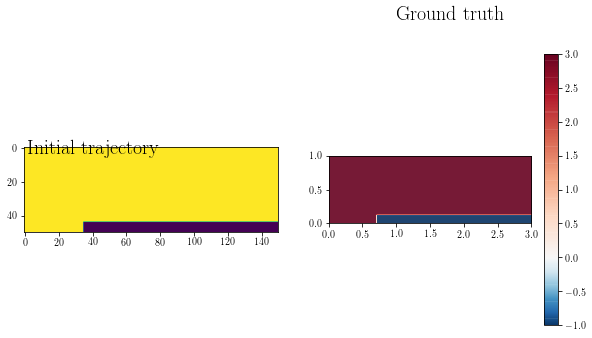

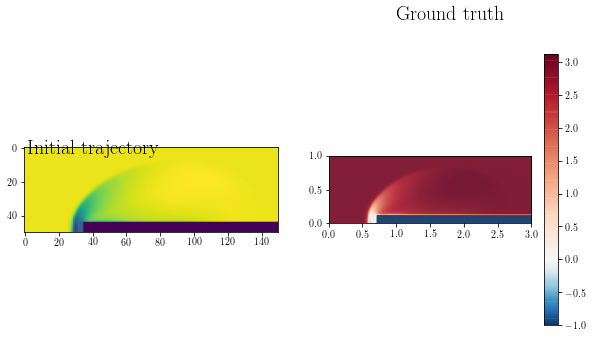

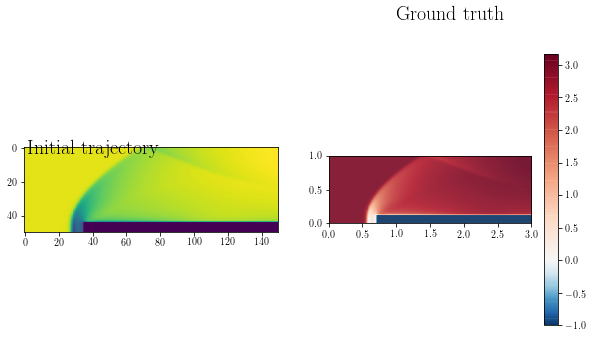

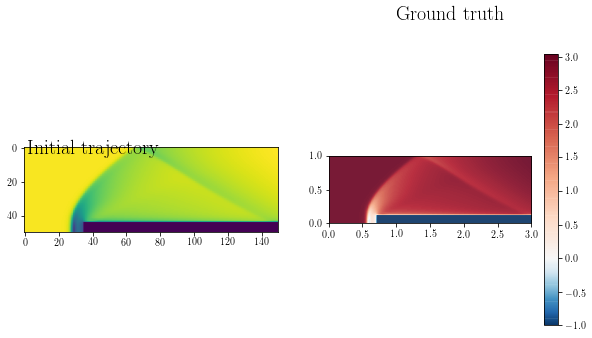

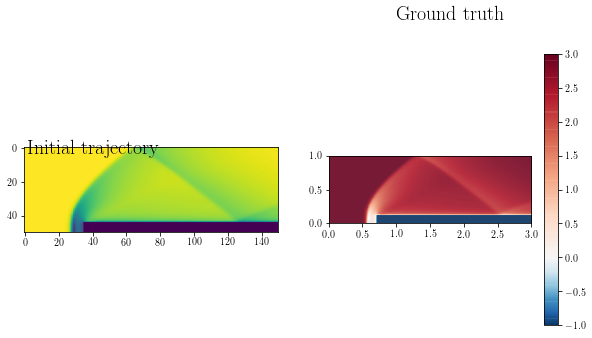

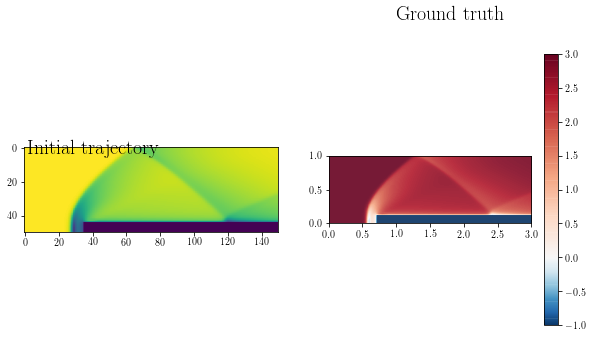

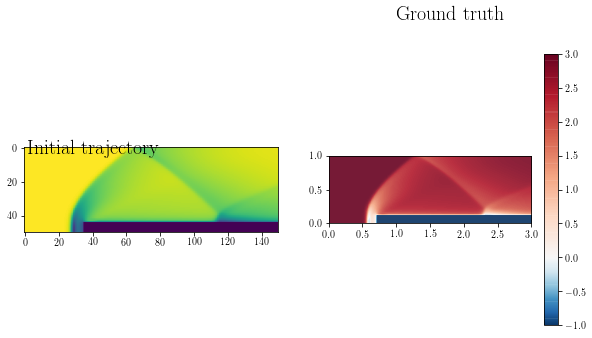

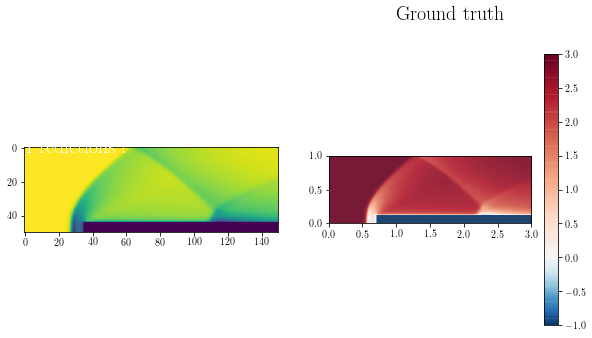

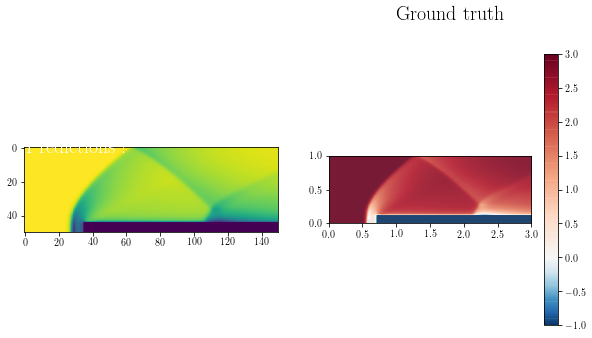

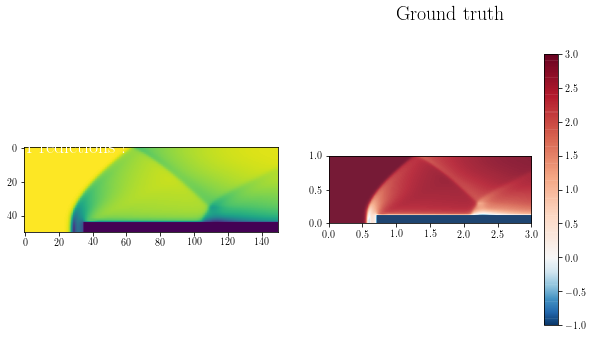

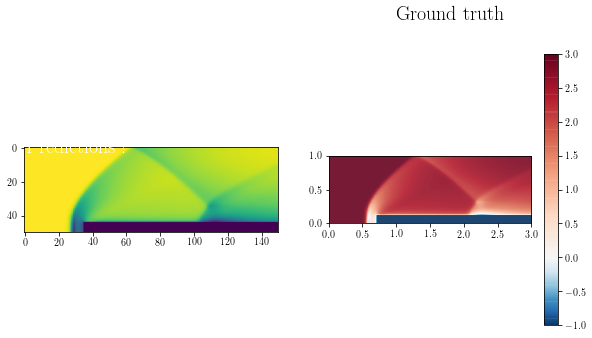

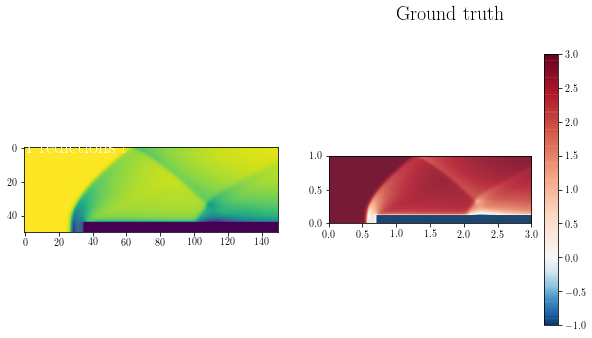

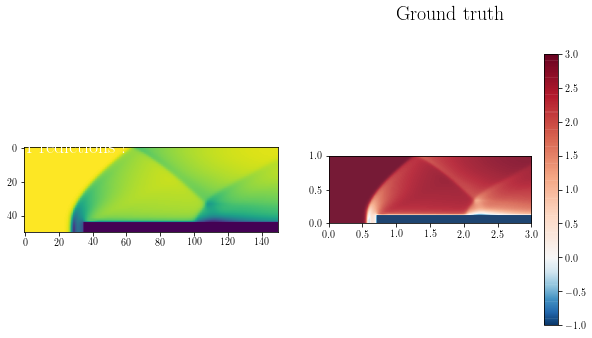

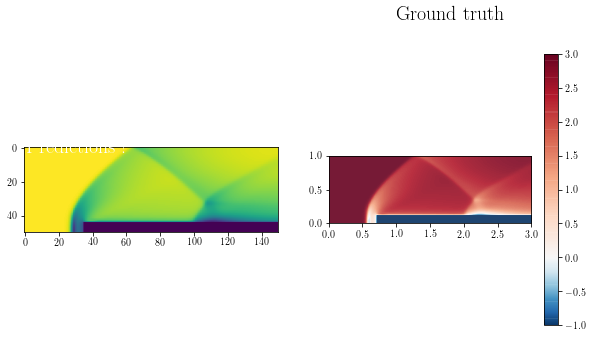

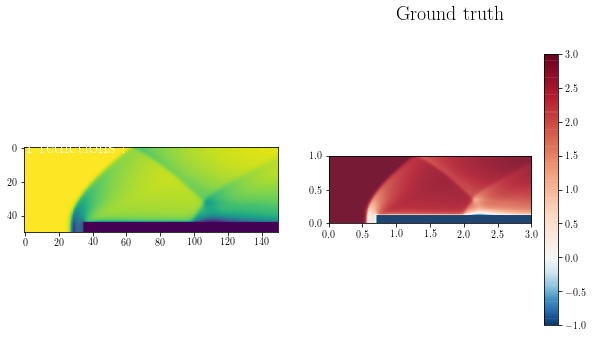

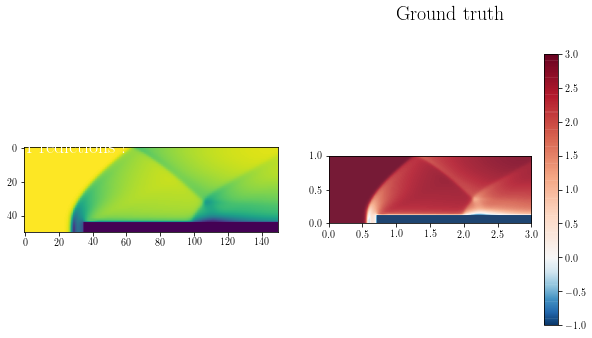

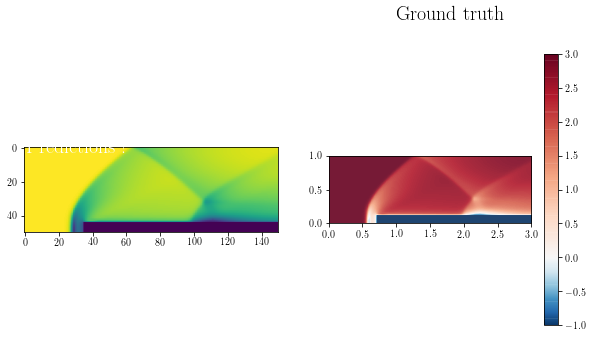

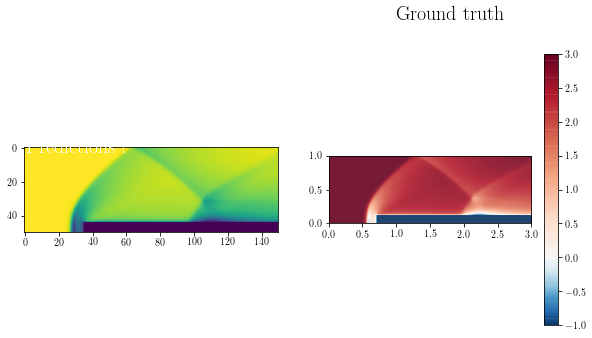

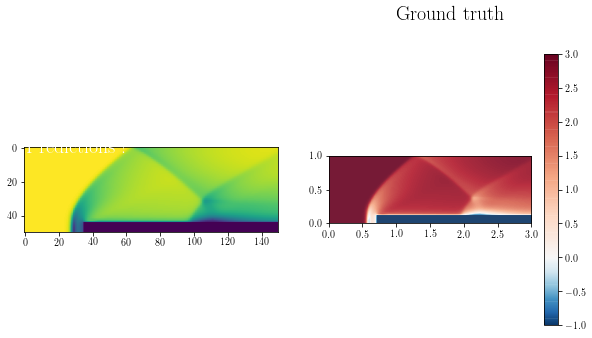

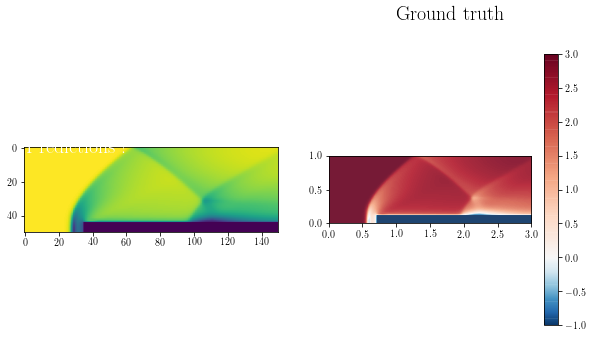

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def read_dataset(path=None, split=0.9, print_shape=False):
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][180:190, 0:20, ...]
    y = hdf5_file["sim_data"][180:190, 1:21, ...]
    sim_no = hdf5_file["sim_no"][:, 0]
    hdf5_file.close()

    total_sim = x.shape[0]
    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test, sim_no_train, sim_no_test

path='/content/Plots_predict/'

try:
    shutil.rmtree(path)
except OSError as e:
    print ("")

os.makedirs(path)

hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test, _, _ = read_dataset(path=hdf5_path, split=0.9, print_shape=True)
model = load_model('my_model3.h5')


which = 0
track = x_test[which, ...]

for j in range(20):
    new_pos = model.predict(track[np.newaxis, 0:20, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)



class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# And then compare the predictions
# to the ground truth
track2 = x_test[which][::, ::, ::, ::]
for i in range(20):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = y_test[which][i - 1, ::, ::, 0]

    extent = 0, 3, 0, 1
    im = plt.imshow(toplot, cmap='RdBu_r', alpha=.9, interpolation='bilinear', norm=MidpointNormalize(midpoint=0.), extent=extent)
    plt.colorbar();
    plt.savefig('/content/Plots_predict/%i_animate.png' % (i + 1))

# MODELOS ALTERNATIVOS:

1---
MODEL OF CONVLSTM2D WITH RESNET

In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.callbacks import EarlyStopping
import h5py


def read_dataset(path=None, split=0.8, print_shape=False):
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:, 0:9, ...]
    y = hdf5_file["sim_data"][:, 1:10, ...]
    sim_no = hdf5_file["sim_no"][:, 0]
    hdf5_file.close()

    total_sim = x.shape[0]
    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test, sim_no_train, sim_no_test


def keras_model(layers=3, filters=32, kernel_size=(3, 3), activation='relu', recurrent_activation='tanh', dropout=0.0,
                recurrent_dropout=0.0):
    input_shape = (None, 50, 150, 4)

    seq = Sequential()
    if layers >= 1:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=input_shape,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 2:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 3:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 4:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 5:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 6:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 7:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 8:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 9:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))

    seq.add(Conv3D(filters=4, kernel_size=(3, 3, 3), activation='linear', padding='same', data_format='channels_last'))
    plot_model(model, to_file='convlstm2d_with_resnet.png', show_shapes=True, show_layer_names=False)
    print(seq.summary())
    return seq

lr=1.5e-4
batch_size=5
epochs=50
hdf5_path = '/content/drive/MyDrive/all_data.hdf5'

x_train, y_train, x_test, y_test, _, _ = read_dataset(path=hdf5_path, split=0.9, print_shape=False)

optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)

model = keras_model(layers=3, filters=32, kernel_size=(3, 3), activation='relu', recurrent_activation='tanh',
                    dropout=0.0, recurrent_dropout=0.0)

model.compile(loss='MSE', optimizer=optimizer, metrics=['MSE'])

callbacks = [EarlyStopping(monitor='val_MSE', min_delta=0, patience=10)]

model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks)

model.save('my_model1.h5')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_61 (ConvLSTM2D) (None, None, 50, 150, 32) 41600     
_________________________________________________________________
conv_lst_m2d_62 (ConvLSTM2D) (None, None, 50, 150, 32) 73856     
_________________________________________________________________
conv_lst_m2d_63 (ConvLSTM2D) (None, None, 50, 150, 32) 73856     
_________________________________________________________________
conv3d_19 (Conv3D)           (None, None, 50, 150, 4)  3460      
Total params: 192,772
Trainable params: 192,772
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
18/18 [==============================] - 8s 335ms/step - loss: 5.0585 - MSE: 5.0585 - val_loss: 3.9115 - val_MSE: 3.9115
Epoch 2/50
18/18 [==============================] - 6s 311ms/step - loss: 4.5210 - MSE: 4.5210 - val_loss: 3.

4----
Lstm:


In [1]:
from keras.utils.vis_utils import plot_model

def inception_module(filters=32, inputs=None):
    tower_0 = tf.keras.layers.Conv2D(int(filters / 4), (1, 1), padding='same', activation='relu')(inputs)

    tower_1 = tf.keras.layers.Conv2D(int(filters / 4), (1, 1), padding='same', activation='relu')(inputs)
    tower_1 = tf.keras.layers.Conv2D(int((filters * 3) / 8), (3, 3), padding='same', activation='relu')(tower_1)

    tower_2 = tf.keras.layers.Conv2D(int(filters / 8), (1, 1), padding='same', activation='relu')(inputs)
    tower_2 = tf.keras.layers.Conv2D(int(filters / 8), (5, 5), padding='same', activation='relu')(tower_2)

    tower_3 = tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    tower_3 = tf.keras.layers.Conv2D(int(filters / 4), (1, 1), padding='same', activation='relu')(tower_3)

    concat = tf.keras.layers.Concatenate(axis=3)([tower_0, tower_1, tower_2, tower_3])

    return concat


def cnn_model():
    inputs = tf.keras.Input(shape=(50, 150, 4))

    c1 = inception_module(filters=32, inputs=inputs)  # (None, 50, 150, 32)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(c1)  # (None, 25, 75, 32)

    c2 = inception_module(filters=64, inputs=x)  # (None, 25, 75, 64)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(c2)  # (None, 13, 38, 64)

    c3 = inception_module(filters=128, inputs=x)  # (None, 13, 38, 128)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(c3)  # (None, 7, 19, 128)

    c4 = inception_module(filters=256, inputs=x)  # (None, 7, 19, 256)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(c4)  # (None, 4, 10, 256)

    x = inception_module(filters=512, inputs=x)  # (None, 4, 10, 512)

    x = tf.keras.layers.Add()([tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)))(tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)),
             c4])  # (None, 4, 10, 512) -> (None, 8, 20, 256) -> (None, 7, 19, 256)
    x = tf.keras.layers.Add()([tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)),
             c3])  # (None, 7, 19, 256) -> (None, 14, 38, 128) -> (None, 13, 38, 128)
    x = tf.keras.layers.Add()([tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)))(tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)),
             c2])  # (None, 13, 38, 128) -> (None, 26, 76, 64) -> (None, 25, 75, 64)
    x = tf.keras.layers.Add()([tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x),
             c1])  # ((None, 25, 75, 64) -> (None, 50, 150, 32)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=False)

    return model


def lstm_model_2(save_model=True):
    video_input = Input(shape=(9, 50, 150, 4))

    x = tf.keras.layers.TimeDistributed(cnn_model())(video_input)

    x = tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)
    x = tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)
    x = tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)  # (None, 50, 150, 16)

    x = tf.keras.layers.Conv3D(filters=4, kernel_size=(3, 3, 3), activation='linear', padding='same', data_format='channels_last')(x)

    model = tf.keras.Model(inputs=video_input, outputs=x)
    print(model.summary())

    if save_model:
        plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=False)
    
    return model


lstm_model(save_model=True)

def read_dataset(path=None, split=0.8, print_shape=False):
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:, 0:20, ...]
    y = hdf5_file["sim_data"][:, 1:21, ...]
    sim_no = hdf5_file["sim_no"][:, 0]
    hdf5_file.close()

    total_sim = x.shape[0]
    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test, sim_no_train, sim_no_test

hdf5_path = '/content/drive/MyDrive/all_data.hdf5'

x_train, y_train, x_test, y_test, _, _ = read_dataset(path=hdf5_path, split=0.9, print_shape=False)

#parameters:
lr=1.5e-04
epochs=50
batch_size=5


model = lstm_model_2()


optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)

model.compile(loss='MSE', optimizer=optimizer, metrics=['MSE'])

callbacks = [EarlyStopping(monitor='val_MSE', min_delta=0.001, patience=5)]

train_info = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks)
score = model.evaluate(x=x_test, y=y_test, verbose=2)
print('Average Mean Squared Error:', score[0])
model.save('my_model4.h5')


NameError: ignored